# DASC 10003 Final Project: Forensic Accounting - Detecting Anomalies with Benford’s Law

**Team Roles**:  
- Lead: Ian Horton 
- Scribe: Harlie Lockhart  
- Final Presentation Editor: Tre McEntire
- Final Editor for Report: Harlie Lockhart

**Dataset**: SEC Financial Statements (Q1 2020 - Q4 2024)  
**Hypothesis**: Companies that significantly deviate from Benford’s Law in their reported revenue figures will exhibit higher rates of financial outliers (as measured by z-scores) and weaker revenue-expense correlations compared to companies that conform to Benford’s expected distribution

In [2]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from io import BytesIO
from matplotlib.table import table

# Define directories
data_dir = 'sec_data'
os.makedirs(data_dir, exist_ok=True)

# List of quarters and URLs (from SEC site)
quarters = [
    ('2020q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q1.zip'),
    ('2020q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q2.zip'),
    ('2020q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q3.zip'),
    ('2020q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2020q4.zip'),
    ('2021q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q1.zip'),
    ('2021q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q2.zip'),
    ('2021q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q3.zip'),
    ('2021q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2021q4.zip'),
    ('2022q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q1.zip'),
    ('2022q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q2.zip'),
    ('2022q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q3.zip'),
    ('2022q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2022q4.zip'),
    ('2023q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q1.zip'),
    ('2023q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q2.zip'),
    ('2023q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q3.zip'),
    ('2023q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2023q4.zip'),
    ('2024q1', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q1.zip'),
    ('2024q2', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q2.zip'),
    ('2024q3', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q3.zip'),
    ('2024q4', 'https://www.sec.gov/files/dera/data/financial-statement-data-sets/2024q4.zip')
]

# Relevant XBRL tags (common for US GAAP)
revenue_tags = [
    'Revenues', 
    'RevenueFromContractWithCustomerExcludingAssessedTax', 
    'RevenueFromContractWithCustomerIncludingAssessedTax', 
    'SalesRevenueNet'
]
expenses_tags = [
    'OperatingExpenses', 
    'SellingGeneralAndAdministrativeExpense', 
    'CostOfGoodsSold', 
    'OperatingCostsAndExpenses'
]
all_tags = revenue_tags + expenses_tags

# already ran (only needs one pass)

import time

def download_zip(url, save_path, retries=3):
    if os.path.exists(save_path):
        print(f"{save_path} already exists.")
        return

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36',
        'Accept': '*/*',
        'Accept-Language': 'en-US,en;q=0.9',
        'Connection': 'keep-alive',
    }

    for attempt in range(retries):
        try:
            print(f"Downloading {url} (attempt {attempt + 1})...")
            response = requests.get(url, headers=headers, timeout=30, stream=True)
            response.raise_for_status()

            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Saved to {save_path}")
            return

        except requests.exceptions.HTTPError as e:
            if response.status_code == 403:
                print("403 Forbidden - access denied. Check headers or auth.")
            else:
                print(f"HTTP {response.status_code}: {e}")
        except Exception as e:
            print(f"Error: {e}")
        
        if attempt < retries - 1:
            time.sleep(5)

    print(f"Failed to download {url}")

# Usage
for quarter, url in quarters:
    zip_path = os.path.join(data_dir, f"{quarter}.zip")
    download_zip(url, zip_path)

In [3]:
# Lists to hold data
all_num = []
all_sub = []

for quarter, url in quarters:
    zip_path = os.path.join(data_dir, f"{quarter}.zip")
    print(f"Processing {quarter}...")
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Load sub.txt
        sub_df = pd.read_csv(z.open('sub.txt'), sep='\t', dtype={'cik': str, 'sic': str})
        all_sub.append(sub_df[['adsh', 'cik', 'name', 'sic', 'period', 'fy', 'fp']])
        
        # Load num.txt (filtered)
        num_df = pd.read_csv(
            z.open('num.txt'), 
            sep='\t', 
            usecols=['adsh', 'tag', 'ddate', 'uom', 'value'],
            dtype={'adsh': str, 'ddate': str, 'value': float}
        )
        num_df = num_df[num_df['tag'].isin(all_tags)]
        num_df = num_df[(num_df['uom'] == 'USD') & (num_df['value'] > 0)]
        all_num.append(num_df)

# Concatenate
num_data = pd.concat(all_num, ignore_index=True)
sub_data = pd.concat(all_sub, ignore_index=True)

# Merge on adsh
data = num_data.merge(sub_data, on='adsh', how='left')

# Convert dates
data['ddate'] = pd.to_datetime(data['ddate'], format='%Y%m%d', errors='coerce')
data['period'] = pd.to_datetime(data['period'], format='%Y%m%d', errors='coerce')

# Handle missing/outliers preliminarily
data = data.dropna(subset=['value', 'ddate'])
data = data[data['value'] > 0]  # For Benford

print(data.shape)
data.head()

Processing 2020q1...
Processing 2020q2...
Processing 2020q3...
Processing 2020q4...
Processing 2021q1...
Processing 2021q2...
Processing 2021q3...
Processing 2021q4...
Processing 2022q1...
Processing 2022q2...
Processing 2022q3...
Processing 2022q4...
Processing 2023q1...
Processing 2023q2...
Processing 2023q3...
Processing 2023q4...
Processing 2024q1...
Processing 2024q2...
Processing 2024q3...
Processing 2024q4...
(3350857, 11)


,adsh,tag,ddate,uom,value,cik,name,sic,period,fy,fp
0,0001393883-20-000011,RevenueFromContractWithCustomerExcludingAssess...,2018-12-31,USD,9312000.0,1393883,"DHI GROUP, INC.",7389,2019-12-31,2019.0,FY
1,0001558235-20-000004,Revenues,2018-06-30,USD,55403000.0,1558235,CORPORATE PROPERTY ASSOCIATES 18 GLOBAL INC,6798,2019-12-31,2019.0,FY
2,0001709682-20-000017,Revenues,2018-12-31,USD,68688000.0,1709682,"NESCO HOLDINGS, INC.",7359,2019-12-31,2019.0,FY
3,0001539894-20-000012,Revenues,2016-12-31,USD,177579000.0,1539894,"ATLAS FINANCIAL HOLDINGS, INC.",6331,2018-12-31,2018.0,FY
4,0000067887-20-000011,Revenues,2018-12-31,USD,304045000.0,67887,MOOG INC.,3590,2019-12-31,2020.0,Q1


                               ddate         value  \
count                        3350857  3.350857e+06   
mean   2021-09-28 15:42:03.868848384  1.031394e+09   
min              2000-12-31 00:00:00  1.000000e-02   
25%              2020-06-30 00:00:00  6.945000e+06   
50%              2021-09-30 00:00:00  6.116700e+07   
75%              2022-12-31 00:00:00  3.670000e+08   
max              2031-09-30 00:00:00  1.599300e+12   
std                              NaN  8.126595e+09   

                              period            fy  
count                        3350852  3.238251e+06  
mean   2022-05-09 03:57:32.452569600  2.021761e+03  
min              2004-12-31 00:00:00  2.004000e+03  
25%              2020-12-31 00:00:00  2.021000e+03  
50%              2022-06-30 00:00:00  2.022000e+03  
75%              2023-06-30 00:00:00  2.023000e+03  
max              2024-12-31 00:00:00  2.025000e+03  
std                              NaN  1.496638e+00  


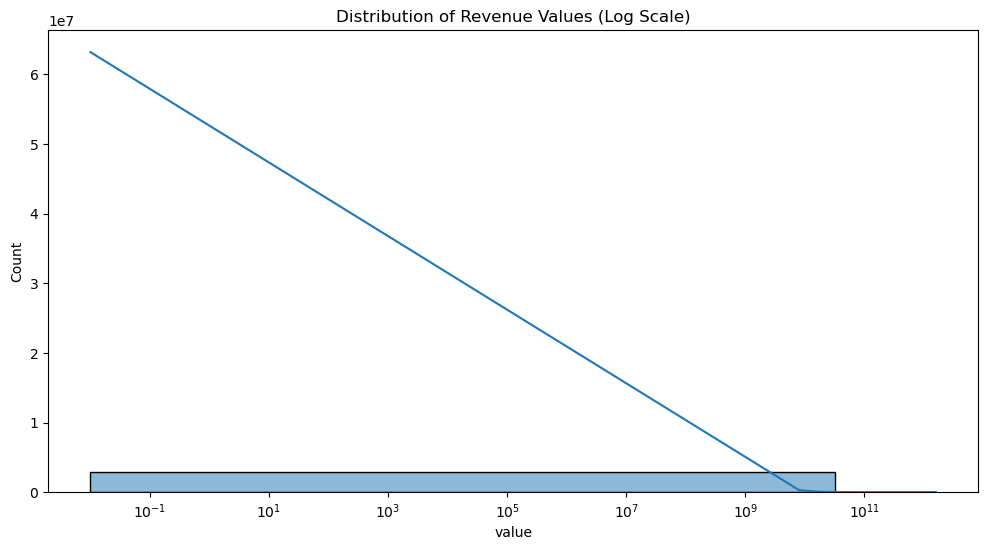

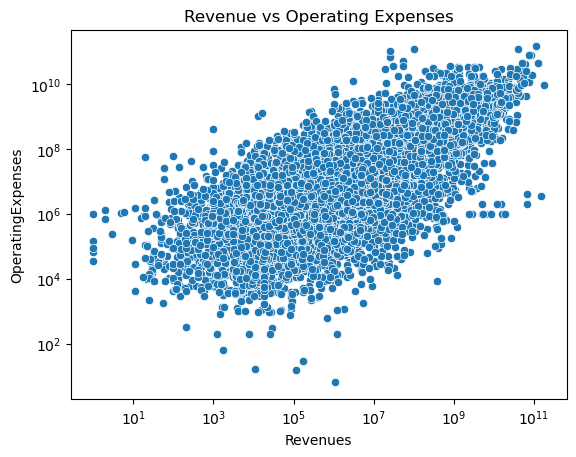

In [4]:
# Summary statistics
print(data.describe())

# Group by tag
data.groupby('tag')['value'].describe()

# Visualizations
plt.figure(figsize=(12, 6))

# Histogram of revenue (log scale)
sns.histplot(data[data['tag'].isin(revenue_tags)]['value'], bins=50, kde=True)
plt.title('Distribution of Revenue Values (Log Scale)')
plt.xscale('log')
plt.savefig('Distribution_of_Revenue_Values_log_scale.png')
plt.show()
plt.close()

# Boxplot by industry (SIC)
#sns.boxplot(x='sic', y='value', data=data[data['tag'].isin(revenue_tags)])
#plt.title('Revenue by Industry (SIC)')
#plt.xticks(rotation=90)
#plt.yscale('log')
#plt.savefig('Revenue_by_Industry_SIC.png')
#plt.show()
#plt.close()

#the above plot was insanely congested. new plot is created in separate code block below

# Scatter: Revenue vs Expenses
rev_exp = data.pivot_table(index=['cik', 'period'], columns='tag', values='value', aggfunc='first')
rev_exp = rev_exp.dropna(subset=revenue_tags + expenses_tags, how='all')
sns.scatterplot(x=rev_exp[revenue_tags[0]], y=rev_exp[expenses_tags[0]])
plt.title('Revenue vs Operating Expenses')
plt.xscale('log')
plt.yscale('log')
plt.savefig('Revenue_vs_Operating_Expenses.png')
plt.show()
plt.close()

/var/folders/sb/xm82dx811tz1w58b1gl9nkhr0000gn/T/ipykernel_69833/495810616.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['industry'] = filtered_data['sic'].map(sic_map).fillna(filtered_data['sic'])  # Fallback to SIC if no map


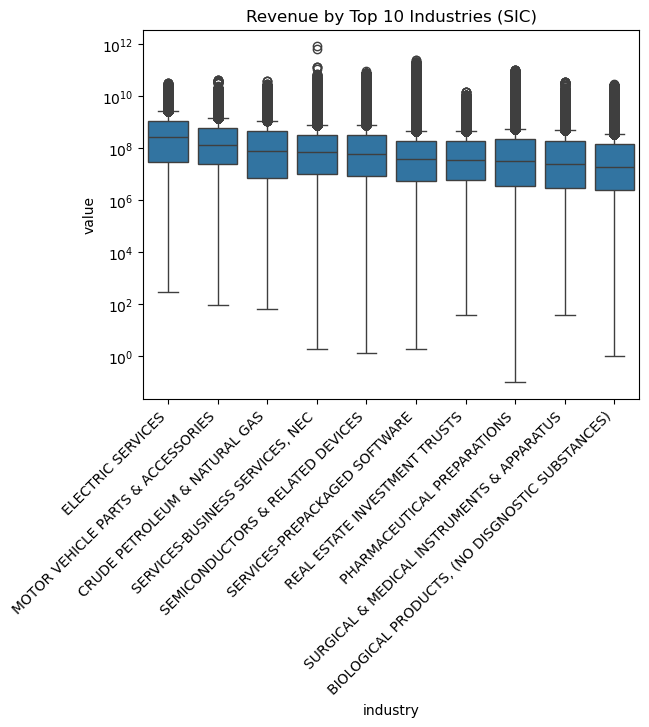

In [5]:
# First, filter to revenue data
revenue_data = data[data['tag'].isin(revenue_tags)]

# Calculate top 10 SIC codes by number of entries (for example; you can change to .sum() for total revenue)
top_sic = revenue_data['sic'].value_counts().head(10).index

# Filter the data to only these top 10 SIC
filtered_data = revenue_data[revenue_data['sic'].isin(top_sic)]

# Optional: Map SIC to industry names using the dict from the tool (copy this dict into your notebook)
sic_map = {
    '100': 'AGRICULTURAL PRODUCTION-CROPS',
    '200': 'AGRICULTURAL PROD-LIVESTOCK & ANIMAL SPECIALTIES',
    '700': 'AGRICULTURAL SERVICES',
    '800': 'FORESTRY',
    '900': 'FISHING, HUNTING AND TRAPPING',
    '1000': 'METAL MINING',
    '1040': 'GOLD AND SILVER ORES',
    '1090': 'MISCELLANEOUS METAL ORES',
    '1220': 'BITUMINOUS COAL & LIGNITE MINING',
    '1221': 'BITUMINOUS COAL & LIGNITE SURFACE MINING',
    '1311': 'CRUDE PETROLEUM & NATURAL GAS',
    '1381': 'DRILLING OIL & GAS WELLS',
    '1382': 'OIL & GAS FIELD EXPLORATION SERVICES',
    '1389': 'OIL & GAS FIELD SERVICES, NEC',
    '1400': 'MINING & QUARRYING OF NONMETALLIC MINERALS (NO FUELS)',
    '1520': 'GENERAL BLDG CONTRACTORS - RESIDENTIAL BLDGS',
    '1531': 'OPERATIVE BUILDERS',
    '1540': 'GENERAL BLDG CONTRACTORS - NONRESIDENTIAL BLDGS',
    '1600': 'HEAVY CONSTRUCTION OTHER THAN BLDG CONST - CONTRACTORS',
    '1623': 'WATER, SEWER, PIPELINE, COMM & POWER LINE CONSTRUCTION',
    '1700': 'CONSTRUCTION - SPECIAL TRADE CONTRACTORS',
    '1731': 'ELECTRICAL WORK',
    '2000': 'FOOD AND KINDRED PRODUCTS',
    '2011': 'MEAT PACKING PLANTS',
    '2013': 'SAUSAGES & OTHER PREPARED MEAT PRODUCTS',
    '2015': 'POULTRY SLAUGHTERING AND PROCESSING',
    '2020': 'DAIRY PRODUCTS',
    '2024': 'ICE CREAM & FROZEN DESSERTS',
    '2030': 'CANNED, FROZEN & PRESERVD FRUIT, VEG & FOOD SPECIALTIES',
    '2033': 'CANNED, FRUITS, VEG, PRESERVES, JAMS & JELLIES',
    '2040': 'GRAIN MILL PRODUCTS',
    '2050': 'BAKERY PRODUCTS',
    '2052': 'COOKIES & CRACKERS',
    '2060': 'SUGAR & CONFECTIONERY PRODUCTS',
    '2070': 'FATS & OILS',
    '2080': 'BEVERAGES',
    '2082': 'MALT BEVERAGES',
    '2086': 'BOTTLED & CANNED SOFT DRINKS & CARBONATED WATERS',
    '2090': 'MISCELLANEOUS FOOD PREPARATIONS & KINDRED PRODUCTS',
    '2092': 'PREPARED FRESH OR FROZEN FISH & SEAFOODS',
    '2100': 'TOBACCO PRODUCTS',
    '2111': 'CIGARETTES',
    '2200': 'TEXTILE MILL PRODUCTS',
    '2211': 'BROADWOVEN FABRIC MILLS, COTTON',
    '2221': 'BROADWOVEN FABRIC MILLS, MAN MADE FIBER & SILK',
    '2250': 'KNITTING MILLS',
    '2253': 'KNIT OUTERWEAR MILLS',
    '2273': 'CARPETS & RUGS',
    '2300': 'APPAREL & OTHER FINISHD PRODS OF FABRICS & SIMILAR MATL',
    '2320': "MEN'S & BOYS' FURNISHGS, WORK CLOTHG, & ALLIED GARMENTS",
    '2330': "WOMEN'S, MISSES', AND JUNIORS OUTERWEAR",
    '2340': "WOMEN'S, MISSES', CHILDREN'S & INFANTS' UNDERGARMENTS",
    '2390': 'MISCELLANEOUS FABRICATED TEXTILE PRODUCTS',
    '2400': 'LUMBER & WOOD PRODUCTS (NO FURNITURE)',
    '2421': 'SAWMILLS & PLANTING MILLS, GENERAL',
    '2430': 'MILLWOOD, VENEER, PLYWOOD, & STRUCTURAL WOOD MEMBERS',
    '2451': 'MOBILE HOMES',
    '2452': 'PREFABRICATED WOOD BLDGS & COMPONENTS',
    '2510': 'HOUSEHOLD FURNITURE',
    '2511': 'WOOD HOUSEHOLD FURNITURE, (NO UPHOLSTERED)',
    '2520': 'OFFICE FURNITURE',
    '2522': 'OFFICE FURNITURE (NO WOOD)',
    '2531': 'PUBLIC BLDG & RELATED FURNITURE',
    '2540': 'PARTITIONS, SHELVG, LOCKERS, & OFFICE & STORE FIXTURES',
    '2590': 'MISCELLANEOUS FURNITURE & FIXTURES',
    '2600': 'PAPERS & ALLIED PRODUCTS',
    '2611': 'PULP MILLS',
    '2621': 'PAPER MILLS',
    '2631': 'PAPERBOARD MILLS',
    '2650': 'PAPERBOARD CONTAINERS & BOXES',
    '2670': 'CONVERTED PAPER & PAPERBOARD PRODS (NO CONTANERS/BOXES)',
    '2673': 'PLASTICS, FOIL & COATED PAPER BAGS',
    '2711': 'NEWSPAPERS: PUBLISHING OR PUBLISHING & PRINTING',
    '2721': 'PERIODICALS: PUBLISHING OR PUBLISHING & PRINTING',
    '2731': 'BOOKS: PUBLISHING OR PUBLISHING & PRINTING',
    '2732': 'BOOK PRINTING',
    '2741': 'MISCELLANEOUS PUBLISHING',
    '2750': 'COMMERCIAL PRINTING',
    '2761': 'MANIFOLD BUSINESS FORMS',
    '2771': 'GREETING CARDS',
    '2780': 'BLANKBOOKS, LOOSELEAF BINDERS & BOOKBINDG & RELATD WORK',
    '2790': 'SERVICE INDUSTRIES FOR THE PRINTING TRADE',
    '2800': 'CHEMICALS & ALLIED PRODUCTS',
    '2810': 'INDUSTRIAL INORGANIC CHEMICALS',
    '2820': 'PLASTIC MATERIAL, SYNTH RESIN/RUBBER, CELLULOS (NO GLASS)',
    '2821': 'PLASTIC MATERIALS, SYNTH RESINS & NONVULCAN ELASTOMERS',
    '2833': 'MEDICINAL CHEMICALS & BOTANICAL PRODUCTS',
    '2834': 'PHARMACEUTICAL PREPARATIONS',
    '2835': 'IN VITRO & IN VIVO DIAGNOSTIC SUBSTANCES',
    '2836': 'BIOLOGICAL PRODUCTS, (NO DISGNOSTIC SUBSTANCES)',
    '2840': 'SOAP, DETERGENTS, CLEANG PREPARATIONS, PERFUMES, COSMETICS',
    '2842': 'SPECIALTY CLEANING, POLISHING AND SANITATION PREPARATIONS',
    '2844': 'PERFUMES, COSMETICS & OTHER TOILET PREPARATIONS',
    '2851': 'PAINTS, VARNISHES, LACQUERS, ENAMELS & ALLIED PRODS',
    '2860': 'INDUSTRIAL ORGANIC CHEMICALS',
    '2870': 'AGRICULTURAL CHEMICALS',
    '2890': 'MISCELLANEOUS CHEMICAL PRODUCTS',
    '2891': 'ADHESIVES & SEALANTS',
    '2911': 'PETROLEUM REFINING',
    '2950': 'ASPHALT PAVING & ROOFING MATERIALS',
    '2990': 'MISCELLANEOUS PRODUCTS OF PETROLEUM & COAL',
    '3011': 'TIRES & INNER TUBES',
    '3021': 'RUBBER & PLASTICS FOOTWEAR',
    '3050': 'GASKETS, PACKG & SEALG DEVICES & RUBBER & PLASTICS HOSE',
    '3060': 'FABRICATED RUBBER PRODUCTS, NEC',
    '3080': 'MISCELLANEOUS PLASTICS PRODUCTS',
    '3081': 'UNSUPPORTED PLASTICS FILM & SHEET',
    '3086': 'PLASTICS FOAM PRODUCTS',
    '3089': 'PLASTICS PRODUCTS, NEC',
    '3100': 'LEATHER & LEATHER PRODUCTS',
    '3140': 'FOOTWEAR, (NO RUBBER)',
    '3211': 'FLAT GLASS',
    '3220': 'GLASS & GLASSWARE, PRESSED OR BLOWN',
    '3221': 'GLASS CONTAINERS',
    '3231': 'GLASS PRODUCTS, MADE OF PURCHASED GLASS',
    '3241': 'CEMENT, HYDRAULIC',
    '3250': 'STRUCTURAL CLAY PRODUCTS',
    '3260': 'POTTERY & RELATED PRODUCTS',
    '3270': 'CONCRETE, GYPSUM & PLASTER PRODUCTS',
    '3272': 'CONCRETE PRODUCTS, EXCEPT BLOCK & BRICK',
    '3281': 'CUT STONE & STONE PRODUCTS',
    '3290': 'ABRASIVE, ASBESTOS & MISC NONMETALLIC MINERAL PRODS',
    '3310': 'STEEL WORKS, BLAST FURNACES & ROLLING & FINISHING MILLS',
    '3312': 'STEEL WORKS, BLAST FURNACES & ROLLING MILLS (COKE OVENS)',
    '3317': 'STEEL PIPE & TUBES',
    '3320': 'IRON & STEEL FOUNDRIES',
    '3330': 'PRIMARY SMELTING & REFINING OF NONFERROUS METALS',
    '3334': 'PRIMARY PRODUCTION OF ALUMINUM',
    '3341': 'SECONDARY SMELTING & REFINING OF NONFERROUS METALS',
    '3350': 'ROLLING DRAWING & EXTRUDING OF NONFERROUS METALS',
    '3357': 'DRAWING & INSULATING OF NONFERROUS WIRE',
    '3360': 'NONFERROUS FOUNDRIES (CASTINGS)',
    '3390': 'MISCELLANEOUS PRIMARY METAL PRODUCTS',
    '3411': 'METAL CANS',
    '3412': 'METAL SHIPPING BARRELS, DRUMS, KEGS & PAILS',
    '3420': 'CUTLERY, HANDTOOLS & GENERAL HARDWARE',
    '3430': 'HEATING EQUIP, EXCEPT ELEC & WARM AIR; & PLUMBING FIXTURES',
    '3433': 'HEATING EQUIPMENT, EXCEPT ELECTRIC & WARM AIR FURNACES',
    '3440': 'FABRICATED STRUCTURAL METAL PRODUCTS',
    '3442': 'METAL DOORS, SASH, FRAMES, MOLDINGS & TRIM',
    '3443': 'FABRICATED PLATE WORK (BOILER SHOPS)',
    '3444': 'SHEET METAL WORK',
    '3448': 'PREFABRICATED METAL BUILDINGS & COMPONENTS',
    '3451': 'SCREW MACHINE PRODUCTS',
    '3452': 'BOLTS, NUTS, SCREWS, RIVETS & WASHERS',
    '3460': 'METAL FORGINGS & STAMPINGS',
    '3470': 'COATING, ENGRAVING & ALLIED SERVICES',
    '3480': 'ORDNANCE & ACCESSORIES, (NO VEHICLES/GUIDED MISSILES)',
    '3490': 'MISCELLANEOUS FABRICATED METAL PRODUCTS',
    '3510': 'ENGINES & TURBINES',
    '3523': 'FARM MACHINERY & EQUIPMENT',
    '3524': 'LAWN & GARDEN TRACTORS & HOME LAWN & GARDENS EQUIP',
    '3530': 'CONSTRUCTION, MINING & MATERIALS HANDLING MACHINERY & EQUIP',
    '3531': 'CONSTRUCTION MACHINERY & EQUIP',
    '3532': 'MINING MACHINERY & EQUIP (NO OIL & GAS FIELD MACH & EQUIP)',
    '3533': 'OIL & GAS FIELD MACHINERY & EQUIPMENT',
    '3537': 'INDUSTRIAL TRUCKS, TRACTORS, TRAILORS & STACKERS',
    '3540': 'METALWORKG MACHINERY & EQUIPMENT',
    '3541': 'MACHINE TOOLS, METAL CUTTING TYPES',
    '3550': 'SPECIAL INDUSTRY MACHINERY (NO METALWORKING MACHINERY)',
    '3555': 'PRINTING TRADES MACHINERY & EQUIPMENT',
    '3559': 'SPECIAL INDUSTRY MACHINERY, NEC',
    '3560': 'GENERAL INDUSTRIAL MACHINERY & EQUIPMENT',
    '3561': 'PUMPS & PUMPING EQUIPMENT',
    '3562': 'BALL & ROLLER BEARINGS',
    '3564': 'INDUSTRIAL & COMMERCIAL FANS & BLOWERS & AIR PURIFING EQUIP',
    '3567': 'INDUSTRIAL PROCESS FURNACES & OVENS',
    '3569': 'GENERAL INDUSTRIAL MACHINERY & EQUIPMENT, NEC',
    '3570': 'COMPUTER & OFFICE EQUIPMENT',
    '3571': 'ELECTRONIC COMPUTERS',
    '3572': 'COMPUTER STORAGE DEVICES',
    '3575': 'COMPUTER TERMINALS',
    '3576': 'COMPUTER COMMUNICATIONS EQUIPMENT',
    '3577': 'COMPUTER PERIPHERAL EQUIPMENT, NEC',
    '3578': 'CALCULATING & ACCOUNTING MACHINES (NO ELECTRONIC COMPUTERS)',
    '3579': 'OFFICE MACHINES, NEC',
    '3580': 'REFRIGERATION & SERVICE INDUSTRY MACHINERY',
    '3585': 'AIR-COND & WARM AIR HEATG EQUIP & COMM & INDL REFRIG EQUIP',
    '3590': 'MISC INDUSTRIAL & COMMERCIAL MACHINERY & EQUIPMENT',
    '3600': 'ELECTRONIC & OTHER ELECTRICAL EQUIPMENT (NO COMPUTER EQUIP)',
    '3612': 'POWER, DISTRIBUTION & SPECIALTY TRANSFORMERS',
    '3613': 'SWITCHGEAR & SWITCHBOARD APPARATUS',
    '3620': 'ELECTRICAL INDUSTRIAL APPARATUS',
    '3621': 'MOTORS & GENERATORS',
    '3630': 'HOUSEHOLD APPLIANCES',
    '3634': 'ELECTRIC HOUSEWARES & FANS',
    '3640': 'ELECTRIC LIGHTING & WIRING EQUIPMENT',
    '3651': 'HOUSEHOLD AUDIO & VIDEO EQUIPMENT',
    '3652': 'PHONOGRAPH RECORDS & PRERECORDED AUDIO TAPES & DISKS',
    '3661': 'TELEPHONE & TELEGRAPH APPARATUS',
    '3663': 'RADIO & TV BROADCASTING & COMMUNICATIONS EQUIPMENT',
    '3669': 'COMMUNICATIONS EQUIPMENT, NEC',
    '3670': 'ELECTRONIC COMPONENTS & ACCESSORIES',
    '3672': 'PRINTED CIRCUIT BOARDS',
    '3674': 'SEMICONDUCTORS & RELATED DEVICES',
    '3677': 'ELECTRONIC COILS, TRANSFORMERS & OTHER INDUCTORS',
    '3678': 'ELECTRONIC CONNECTORS',
    '3679': 'ELECTRONIC COMPONENTS, NEC',
    '3690': 'MISCELLANEOUS ELECTRICAL MACHINERY, EQUIPMENT & SUPPLIES',
    '3695': 'MAGNETIC & OPTICAL RECORDING MEDIA',
    '3711': 'MOTOR VEHICLES & PASSENGER CAR BODIES',
    '3713': 'TRUCK & BUS BODIES',
    '3714': 'MOTOR VEHICLE PARTS & ACCESSORIES',
    '3716': 'MOTOR HOMES',
    '3720': 'AIRCRAFT & PARTS',
    '3721': 'AIRCRAFT',
    '3724': 'AIRCRAFT ENGINES & ENGINE PARTS',
    '3728': 'AIRCRAFT PARTS & AUXILIARY EQUIPMENT, NEC',
    '3730': 'SHIP & BOAT BUILDING & REPAIRING',
    '3743': 'RAILROAD EQUIPMENT',
    '3751': 'MOTORCYCLES, BICYCLES & PARTS',
    '3760': 'GUIDED MISSILES & SPACE VEHICLES & PARTS',
    '3790': 'MISCELLANEOUS TRANSPORTATION EQUIPMENT',
    '3812': 'SEARCH, DETECTION, NAVAGATION, GUIDANCE, AERONAUTICAL SYS',
    '3821': 'LABORATORY APPARATUS & FURNITURE',
    '3822': 'AUTO CONTROLS FOR REGULATING RESIDENTIAL & COMML ENVIRONMENTS',
    '3823': 'INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLAY, AND CONTROL',
    '3824': 'TOTALIZING FLUID METERS & COUNTING DEVICES',
    '3825': 'INSTRUMENTS FOR MEAS & TESTING OF ELECTRICITY & ELEC SIGNALS',
    '3826': 'LABORATORY ANALYTICAL INSTRUMENTS',
    '3827': 'OPTICAL INSTRUMENTS & LENSES',
    '3829': 'MEASURING & CONTROLLING DEVICES, NEC',
    '3841': 'SURGICAL & MEDICAL INSTRUMENTS & APPARATUS',
    '3842': 'ORTHOPEDIC, PROSTHETIC & SURGICAL APPLIANCES & SUPPLIES',
    '3843': 'DENTAL EQUIPMENT & SUPPLIES',
    '3844': 'X-RAY APPARATUS & TUBES & RELATED IRRADIATION APPARATUS',
    '3845': 'ELECTROMEDICAL & ELECTROTHERAPEUTIC APPARATUS',
    '3851': 'OPHTHALMIC GOODS',
    '3861': 'PHOTOGRAPHIC EQUIPMENT & SUPPLIES',
    '3873': 'WATCHES, CLOCKS, CLOCKWORK OPERATED DEVICES/PARTS',
    '3900': 'MISCELLANEOUS MANUFACTURING INDUSTRIES',
    '3910': 'JEWELRY, SILVERWARE & PLATED WARE',
    '3931': 'MUSICAL INSTRUMENTS',
    '3944': 'GAMES, TOYS & CHILDRENS VEHICLES (NO DOLLS & BICYCLES)',
    '3949': 'SPORTING & ATHLETIC GOODS, NEC',
    '3950': 'PENS, PENCILS & OTHER ARTISTS MATERIALS',
    '3990': 'MISCELLANEOUS MANUFACTURING INDUSTRIES',
    '4011': 'RAILROADS, LINE-HAUL OPERATING',
    '4100': 'LOCAL & SUBURBAN TRANSIT & INTERURBAN HWY PASSENGER TRANS',
    '4210': 'TRUCKING & COURIER SERVICES (NO AIR)',
    '4213': 'TRUCKING (NO LOCAL)',
    '4220': 'PUBLIC WAREHOUSING & STORAGE',
    '4231': 'TERMINAL MAINTENANCE FACILITIES FOR MOTOR FREIGHT TRANSPORT',
    '4610': 'PIPE LINES (NO NATURAL GAS)',
    '4700': 'TRANSPORTATION SERVICES',
    '4731': 'ARRANGEMENT OF TRANSPORTATION OF FREIGHT & CARGO',
    '4812': 'RADIOTELEPHONE COMMUNICATIONS',
    '4813': 'TELEPHONE COMMUNICATIONS (NO RADIOTELEPHONE)',
    '4822': 'TELEGRAPH & OTHER MESSAGE COMMUNICATIONS',
    '4832': 'RADIO BROADCASTING STATIONS',
    '4833': 'TELEVISION BROADCASTING STATIONS',
    '4841': 'CABLE & OTHER PAY TELEVISION SERVICES',
    '4899': 'COMMUNICATIONS SERVICES, NEC',
    '4900': 'ELECTRIC, GAS & SANITARY SERVICES',
    '4911': 'ELECTRIC SERVICES',
    '4922': 'NATURAL GAS TRANSMISSION',
    '4923': 'NATURAL GAS TRANSMISISON & DISTRIBUTION',
    '4924': 'NATURAL GAS DISTRIBUTION',
    '4931': 'ELECTRIC & OTHER SERVICES COMBINED',
    '4932': 'GAS & OTHER SERVICES COMBINED',
    '4941': 'WATER SUPPLY',
    '4950': 'SANITARY SERVICES',
    '4953': 'REFUSE SYSTEMS',
    '4961': 'STEAM & AIR-CONDITIONING SUPPLY',
    '4991': 'COGENERATION SERVICES & SMALL POWER PRODUCERS',
    '5000': 'WHOLESALE-DURABLE GOODS',
    '5010': 'WHOLESALE-MOTOR VEHICLES & MOTOR VEHICLE PARTS & SUPPLIES',
    '5013': 'WHOLESALE-MOTOR VEHICLE SUPPLIES & NEW PARTS',
    '5020': 'WHOLESALE-FURNITURE & HOME FURNISHINGS',
    '5030': 'WHOLESALE-LUMBER & OTHER CONSTRUCTION MATERIALS',
    '5040': 'WHOLESALE-PROFESSIONAL & COMMERCIAL EQUIPMENT & SUPPLIES',
    '5045': 'WHOLESALE-COMPUTERS & PERIPHERAL EQUIPMENT & SOFTWARE',
    '5047': 'WHOLESALE-MEDICAL, DENTAL & HOSPITAL EQUIPMENT & SUPPLIES',
    '5050': 'WHOLESALE-METALS & MINERALS (NO PETROLEUM)',
    '5051': 'WHOLESALE-METALS SERVICE CENTERS & OFFICES',
    '5063': 'WHOLESALE-ELECTRICAL APPARATUS & EQUIPMENT, WIRING SUPPLIES',
    '5064': 'WHOLESALE-ELECTRICAL APPLIANCES, TV & RADIO SETS',
    '5065': 'WHOLESALE-ELECTRONIC PARTS & EQUIPMENT, NEC',
    '5070': 'WHOLESALE-HARDWARE & PLUMBING & HEATING EQUIPMENT & SUPPLIES',
    '5072': 'WHOLESALE-HARDWARE',
    '5080': 'WHOLESALE-MACHINERY, EQUIPMENT & SUPPLIES',
    '5090': 'WHOLESALE-MISC DURABLE GOODS',
    '5094': 'WHOLESALE-JEWELRY, WATCHES, PRECIOUS STONES & METALS',
    '5099': 'WHOLESALE-DURABLE GOODS, NEC',
    '5110': 'WHOLESALE-PAPER & PAPER PRODUCTS',
    '5122': 'WHOLESALE-DRUGS, PROPRIETARIES & DRUGGISTS SUNDRIES',
    '5130': 'WHOLESALE-APPAREL, PIECE GOODS & NOTIONS',
    '5140': 'WHOLESALE-GROCERIES & RELATED PRODUCTS',
    '5141': 'WHOLESALE-GROCERIES, GENERAL LINE',
    '5150': 'WHOLESALE-FARM PRODUCT RAW MATERIALS',
    '5160': 'WHOLESALE-CHEMICALS & ALLIED PRODUCTS',
    '5171': 'WHOLESALE-PETROLEUM BULK STATIONS & TERMINALS',
    '5172': 'WHOLESALE-PETROLEUM & PETROLEUM PRODUCTS (NO BULK STATIONS)',
    '5180': 'WHOLESALE-BEER, WINE & DISTILLED ALCOHOLIC BEVERAGES',
    '5190': 'WHOLESALE-MISCELLANEOUS NONDURABLE GOODS',
    '5200': 'WHOLESALE-BUILDING MATERIALS, HARDWARE, GARDEN SUPPLY',
    '5211': 'RETAIL-LUMBER & OTHER BUILDING MATERIALS DEALERS',
    '5261': 'RETAIL-NURSERIES, LAWN & GARDEN SUPPLY STORES',
    '5271': 'RETAIL-MOBILE HOME DEALERS',
    '5311': 'RETAIL-DEPARTMENT STORES',
    '5331': 'RETAIL-VARIETY STORES',
    '5399': 'RETAIL-MISC GENERAL MERCHANDISE STORES',
    '5400': 'RETAIL-FOOD STORES',
    '5411': 'RETAIL-GROCERY STORES',
    '5412': 'RETAIL-CONVENIENCE STORES',
    '5500': 'RETAIL-AUTO DEALERS & GASOLINE STATIONS',
    '5531': 'RETAIL-AUTO & HOME SUPPLY STORES',
    '5541': 'RETAIL-GASOLINE SERVICE STATIONS',
    '5551': 'RETAIL-BOAT DEALERS',
    '5561': 'RETAIL-RECREATIONAL VEHICLE DEALERS',
    '5571': 'RETAIL-MOTORCYCLE DEALERS',
    '5599': 'RETAIL-AUTOMOTIVE DEALERS, NEC',
    '5600': 'RETAIL-APPAREL & ACCESSORY STORES',
    '5621': "RETAIL-WOMEN'S CLOTHING STORES",
    '5651': 'RETAIL-FAMILY CLOTHING STORES',
    '5661': 'RETAIL-SHOE STORES',
    '5700': 'RETAIL-HOME FURNITURE, FURNISHINGS & EQUIPMENT STORES',
    '5712': 'RETAIL-FURNITURE STORES',
    '5731': 'RETAIL-RADIO, TV & CONSUMER ELECTRONICS STORES',
    '5734': 'RETAIL-COMPUTER & COMPUTER SOFTWARE STORES',
    '5735': 'RETAIL-RECORD & PRERECORDED TAPE STORES',
    '5810': 'RETAIL-EATING & DRINKING PLACES',
    '5812': 'RETAIL-EATING PLACES',
    '5900': 'RETAIL-MISCELLANEOUS RETAIL',
    '5912': 'RETAIL-DRUG STORES AND PROPRIETARY STORES',
    '5940': 'RETAIL-MISCELLANEOUS SHOPPING GOODS STORES',
    '5944': 'RETAIL-JEWELRY STORES',
    '5945': 'RETAIL-HOBBY, TOY & GAME SHOPS',
    '5960': 'RETAIL-NONSTORE RETAILERS',
    '5961': 'RETAIL-CATALOG & MAIL-ORDER HOUSES',
    '5990': 'RETAIL-RETAIL STORES, NEC',
    '6021': 'NATIONAL COMMERCIAL BANKS',
    '6022': 'STATE COMMERCIAL BANKS',
    '6029': 'COMMERCIAL BANKS, NEC',
    '6035': 'SAVINGS INSTITUTION, FEDERALLY CHARTERED',
    '6036': 'SAVINGS INSTITUTIONS, NOT FEDERALLY CHARTERED',
    '6099': 'FUNCTIONS RELATED TO DEPOSITORY BANKING, NEC',
    '6111': 'FEDERAL & FEDERALLY-SPONSORED CREDIT AGENCIES',
    '6141': 'PERSONAL CREDIT INSTITUTIONS',
    '6153': 'SHORT-TERM BUSINESS CREDIT INSTITUTIONS',
    '6159': 'MISCELLANEOUS BUSINESS CREDIT INSTITUTION',
    '6162': 'MORTGAGE BANKERS & LOAN CORRESPONDENTS',
    '6163': 'LOAN BROKERS',
    '6172': 'FINANCE LESSORS',
    '6189': 'ASSET-BACKED SECURITIES',
    '6199': 'FINANCE SERVICES',
    '6200': 'SECURITY & COMMODITY BROKERS, DEALERS, EXCHANGES & SERVICES',
    '6211': 'SECURITY BROKERS, DEALERS & FLOTATION COMPANIES',
    '6221': 'COMMODITY CONTRACTS BROKERS & DEALERS',
    '6282': 'INVESTMENT ADVICE',
    '6311': 'LIFE INSURANCE',
    '6321': 'ACCIDENT & HEALTH INSURANCE',
    '6324': 'HOSPITAL & MEDICAL SERVICE PLANS',
    '6331': 'FIRE, MARINE & CASUALTY INSURANCE',
    '6351': 'SURETY INSURANCE',
    '6361': 'TITLE INSURANCE',
    '6399': 'INSURANCE CARRIERS, NEC',
    '6411': 'INSURANCE AGENTS, BROKERS & SERVICE',
    '6500': 'REAL ESTATE',
    '6512': 'OPERATORS OF NONRESIDENTIAL BUILDINGS',
    '6513': 'OPERATORS OF APARTMENT BUILDINGS',
    '6519': 'LESSORS OF REAL PROPERTY, NEC',
    '6531': 'REAL ESTATE AGENTS & MANAGERS (FOR OTHERS)',
    '6552': 'LAND SUBDIVIDERS & DEVELOPERS (NO CEMETERIES)',
    '6770': 'BLANK CHECKS',
    '6792': 'OIL ROYALTY TRADERS',
    '6794': 'PATENT OWNERS & LESSORS',
    '6795': 'MINERAL ROYALTY TRADERS',
    '6798': 'REAL ESTATE INVESTMENT TRUSTS',
    '6799': 'INVESTORS, NEC',
    '7000': 'HOTELS, ROOMING HOUSES, CAMPS & OTHER LODGING PLACES',
    '7011': 'HOTELS & MOTELS',
    '7200': 'SERVICES-PERSONAL SERVICES',
    '7310': 'SERVICES-ADVERTISING',
    '7311': 'SERVICES-ADVERTISING AGENCIES',
    '7320': 'SERVICES-CONSUMER CREDIT REPORTING, COLLECTION AGENCIES',
    '7330': 'SERVICES-MAILING, REPRODUCTION, COMMERCIAL ART & PHOTOGRAPHY',
    '7331': 'SERVICES-DIRECT MAIL ADVERTISING SERVICES',
    '7340': 'SERVICES-TO DWELLINGS & OTHER BUILDINGS',
    '7350': 'SERVICES-MISCELLANEOUS EQUIPMENT RENTAL & LEASING',
    '7359': 'SERVICES-EQUIPMENT RENTAL & LEASING, NEC',
    '7361': 'SERVICES-EMPLOYMENT AGENCIES',
    '7363': 'SERVICES-HELP SUPPLY SERVICES',
    '7370': 'SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING, ETC.',
    '7371': 'SERVICES-COMPUTER PROGRAMMING SERVICES',
    '7372': 'SERVICES-PREPACKAGED SOFTWARE',
    '7373': 'SERVICES-COMPUTER INTEGRATED SYSTEMS DESIGN',
    '7374': 'SERVICES-COMPUTER PROCESSING & DATA PREPARATION',
    '7377': 'SERVICES-COMPUTER RENTAL & LEASING',
    '7379': 'SERVICES-COMPUTER RELATED SERVICES, NEC',
    '7380': 'SERVICES-MISCELLANEOUS BUSINESS SERVICES',
    '7381': 'SERVICES-DETECTIVE, GUARD & ARMORED CAR SERVICES',
    '7384': 'SERVICES-PHOTOFINISHING LABORATORIES',
    '7385': 'SERVICES-TELEPHONE INTERCONNECT SYSTEMS',
    '7389': 'SERVICES-BUSINESS SERVICES, NEC',
    '7500': 'SERVICES-AUTOMOTIVE REPAIR, SERVICES & PARKING',
    '7510': 'SERVICES-AUTO RENTAL & LEASING (NO DRIVERS)',
    '7600': 'SERVICES-MISCELLANEOUS REPAIR SERVICES',
    '7812': 'SERVICES-MOTION PICTURE & VIDEO TAPE PRODUCTION',
    '7819': 'SERVICES-ALLIED TO MOTION PICTURE PRODUCTION',
    '7822': 'SERVICES-MOTION PICTURE & VIDEO TAPE DISTRIBUTION',
    '7829': 'SERVICES-ALLIED TO MOTION PICTURE DISTRIBUTION',
    '7830': 'SERVICES-MOTION PICTURE THEATERS',
    '7841': 'SERVICES-VIDEO TAPE RENTAL',
    '7900': 'SERVICES-AMUSEMENT & RECREATION SERVICES',
    '7948': 'SERVICES-RACING, INCLUDING TRACK OPERATION',
    '7990': 'SERVICES-MISCELLANEOUS AMUSEMENT & RECREATION',
    '8000': 'SERVICES-HEALTH SERVICES',
    '8011': 'SERVICES-OFFICES & CLINICS OF DOCTORS OF MEDICINE',
    '8050': 'SERVICES-NURSING & PERSONAL CARE FACILITIES',
    '8051': 'SERVICES-SKILLED NURSING CARE FACILITIES',
    '8060': 'SERVICES-HOSPITALS',
    '8062': 'SERVICES-GENERAL MEDICAL & SURGICAL HOSPITALS, NEC',
    '8071': 'SERVICES-MEDICAL LABORATORIES',
    '8082': 'SERVICES-HOME HEALTH CARE SERVICES',
    '8090': 'SERVICES-MISC HEALTH & ALLIED SERVICES, NEC',
    '8093': 'SERVICES-SPECIALTY OUTPATIENT FACILITIES, NEC',
    '8111': 'SERVICES-LEGAL SERVICES',
    '8200': 'SERVICES-EDUCATIONAL SERVICES',
    '8300': 'SERVICES-SOCIAL SERVICES',
    '8351': 'SERVICES-CHILD DAY CARE SERVICES',
    '8600': 'SERVICES-MEMBERSHIP ORGANIZATIONS',
    '8700': 'SERVICES-ENGINEERING, ACCOUNTING, RESEARCH, MANAGEMENT',
    '8711': 'SERVICES-ENGINEERING SERVICES',
    '8721': 'SERVICES-ACCOUNTING, AUDITING, AND BOOKKEEPING SERVICES',
    '8731': 'SERVICES-COMMERCIAL PHYSICAL & BIOLOGICAL RESEARCH',
    '8734': 'SERVICES-TESTING LABORATORIES',
    '8741': 'SERVICES-MANAGEMENT SERVICES',
    '8742': 'SERVICES-MANAGEMENT CONSULTING SERVICES',
    '8744': 'SERVICES-FACILITIES SUPPORT MANAGEMENT SERVICES',
    '8880': 'AMERICAN DEPOSITARY RECEIPTS',
    '8888': 'FOREIGN GOVERNMENTS',
    '8900': 'SERVICES-SERVICES, NEC',
    '9721': 'INTERNATIONAL AFFAIRS',
    '9995': 'NON-OPERATING ESTABLISHMENTS',
}
# Note: SIC codes are often 4 digits, but this map has some 3/2-digit; adjust if your 'sic' is int/string, e.g., filtered_data['sic'] = filtered_data['sic'].astype(str).str.zfill(4)

# Add industry names to filtered_data
filtered_data['industry'] = filtered_data['sic'].map(sic_map).fillna(filtered_data['sic'])  # Fallback to SIC if no map

# Optional: Order by median revenue for better visualization
order = filtered_data.groupby('industry')['value'].median().sort_values(ascending=False).index

# Plot the boxplot
sns.boxplot(x='industry', y='value', data=filtered_data, order=order)
plt.title('Revenue by Top 10 Industries (SIC)')
plt.xticks(rotation=45, ha='right', va='top')
plt.yscale('log')

plt.savefig('Revenue_by_Top_10_Industries.png', bbox_inches='tight')
plt.show()
plt.close()

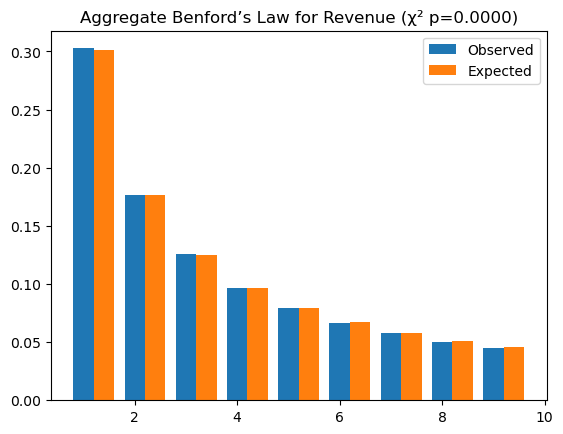

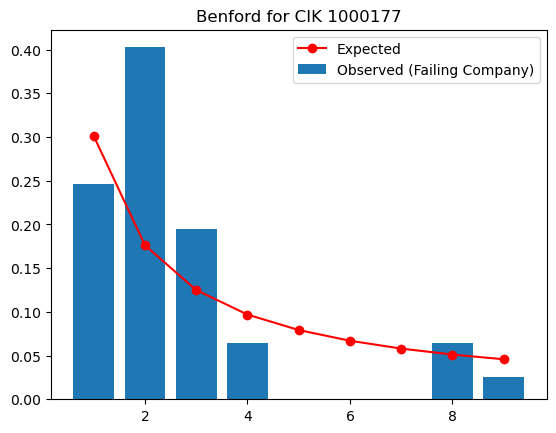

In [6]:
def benford_law(values):
    values = values[values > 0].dropna()
    if len(values) < 10:
        return None, None, None
    
    # Proper leading digit extraction using scientific notation to handle all positive values correctly
    leading_digits = values.apply(lambda x: int(f"{x:e}"[0]))
    observed_counts = pd.Series(leading_digits).value_counts().sort_index().reindex(range(1,10), fill_value=0).values
    n = len(leading_digits)
    
    benford_probs = np.log10(1 + 1 / np.arange(1, 10))
    expected_counts = benford_probs * n
    
    chi2, p = stats.chisquare(observed_counts, expected_counts)
    
    observed = observed_counts / n
    expected = benford_probs
    
    return observed, expected, p

# Apply to revenue per company
benford_results = []
for cik, group in data[data['tag'].isin(revenue_tags)].groupby('cik'):
    values = group['value']
    obs, exp, p = benford_law(values)
    if obs is not None:
        benford_results.append({'cik': cik, 'observed': obs, 'expected': exp, 'benford_p': p})

benford_df = pd.DataFrame(benford_results)

# Flag failing companies (p < 0.05)
benford_df['benford_fail'] = benford_df['benford_p'] < 0.05

# Visualization (aggregate all revenue)
agg_obs, agg_exp, agg_p = benford_law(data[data['tag'].isin(revenue_tags)]['value'])
plt.bar(range(1,10), agg_obs, width=0.4, label='Observed')
plt.bar(np.arange(1,10)+0.4, agg_exp, width=0.4, label='Expected')
plt.title(f'Aggregate Benford’s Law for Revenue (χ² p={agg_p:.4f})')
plt.legend()
plt.savefig('Aggregate_Ben_Law_Revenue.png')
plt.show()
plt.close()

# Example for one failing company
fail_cik = benford_df[benford_df['benford_fail']].iloc[0]['cik']
fail_obs = benford_df[benford_df['cik'] == fail_cik]['observed'].values[0]
plt.bar(range(1,10), fail_obs, label='Observed (Failing Company)')
plt.plot(range(1,10), agg_exp, label='Expected', color='red', marker='o')
plt.title(f'Benford for CIK {fail_cik}')
plt.legend()
plt.savefig('Benford_CIK.png')
plt.show()
plt.close()

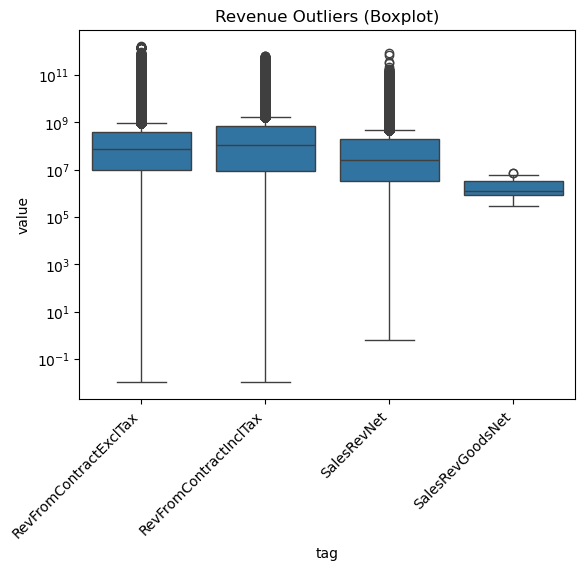

In [11]:
# Z-score per company per tag
data['z_score'] = data.groupby(['cik', 'tag'])['value'].transform(lambda x: (x - x.mean()) / x.std())
data['abs_z'] = abs(data['z_score'])
data['is_outlier'] = data['abs_z'] > 3

# IQR per tag (global, for reference)
for tag in all_tags:
    q1 = data[data['tag'] == tag]['value'].quantile(0.25)
    q3 = data[data['tag'] == tag]['value'].quantile(0.75)
    iqr = q3 - q1
    data.loc[data['tag'] == tag, 'is_outlier_iqr'] = ~data['value'].between(q1 - 1.5*iqr, q3 + 1.5*iqr)

# Your existing code...

sns.boxplot(x='tag', y='value', data=data[data['tag'].isin(revenue_tags)])
plt.title('Revenue Outliers (Boxplot)')
plt.yscale('log')

# Get current tick positions and define short labels (customize these)
tags = data[data['tag'].isin(revenue_tags)]['tag'].unique()
short_labels = [
    'RevFromContractExclTax',  # Abbrev for first tag
    'RevFromContractInclTax',  # Abbrev for second
    'SalesRevNet',             # Abbrev for third
    'SalesRevGoodsNet'         # Abbrev for fourth, if applicable
]

plt.xticks(ticks=range(len(tags)), labels=short_labels, rotation=45, ha='right', va='top')
plt.savefig('revenue_outliers_boxplot.png', bbox_inches='tight')
plt.show()
plt.close()

data columns: Index(['adsh', 'tag', 'ddate', 'uom', 'value', 'cik', 'name', 'sic', 'period',
       'fy', 'fp', 'z_score', 'abs_z', 'is_outlier', 'is_outlier_iqr'],
      dtype='object')
benford_df columns: Index(['cik', 'observed', 'expected', 'benford_p', 'benford_fail'], dtype='object')
Unique tags: ['RevenueFromContractWithCustomerExcludingAssessedTax' 'Revenues'
 'OperatingCostsAndExpenses' 'SellingGeneralAndAdministrativeExpense'
 'RevenueFromContractWithCustomerIncludingAssessedTax' 'OperatingExpenses'
 'SalesRevenueNet' 'CostOfGoodsSold']
Rows per cik: count     8303.000000
mean       403.571842
std        615.547956
min          1.000000
25%         54.000000
50%        180.000000
75%        507.000000
max      11992.000000
dtype: float64
H1 Chi-square p-value: 0.5847241503355562
H2 t-test p-value: 0.09606965813297984
H3 t-test p-value: 0.02995028465338702
          Hypothesis   p-value
0  H1: More Outliers  0.584724
1     H2: Higher |z|  0.096070
2    H3: Weaker Corr  0.02995

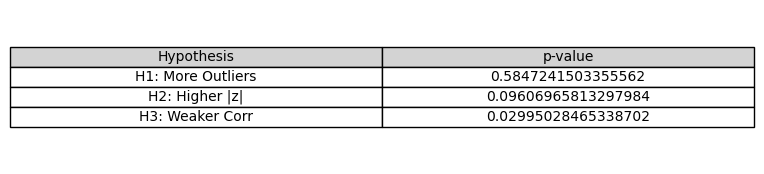

In [8]:
revenue_tags = [
    'Revenues', 'SalesRevenueNet', 'SalesRevenueGoodsNet', 
    'RevenueFromContractWithCustomerExcludingAssessedTax', 'OperatingRevenue', 
    'NetRevenue', 'InterestAndDividendIncomeOperating', 'NoninterestIncome', 
    'InterestIncomeOperating', 'RevenueFromContractWithCustomerIncludingAssessedTax'
]
expenses_tags = [
    'OperatingExpenses', 'CostOfGoodsSold', 'CostOfGoodsAndServicesSold', 
    'SellingGeneralAndAdministrativeExpense', 'CostOfRevenue', 'CostsAndExpenses', 
    'InterestExpense', 'NoninterestExpense', 'OperatingCostsAndExpenses', 
    'SellingAndMarketingExpense', 'GeneralAndAdministrativeExpense'
]

# Assuming 'data' and 'benford_df' are pre-loaded DataFrames with appropriate columns

# Diagnostic: Check columns and data (optional; remove after debugging)
print("data columns:", data.columns)
print("benford_df columns:", benford_df.columns)
print("Unique tags:", data['tag'].unique())  # Verify tags match lists
print("Rows per cik:", data.groupby('cik').size().describe())  # Data volume per company

# Check for required columns
if 'cik' not in benford_df.columns or 'benford_fail' not in benford_df.columns:
    raise ValueError("Missing required columns in benford_df.")
if 'cik' not in data.columns or 'tag' not in data.columns or 'value' not in data.columns or 'period' not in data.columns:
    raise ValueError("Missing required columns in data.")

# Fix: Drop all columns containing 'benford_fail' to clean artifacts
data = data.drop(columns=[col for col in data.columns if 'benford_fail' in col], errors='ignore')

data = data.merge(benford_df[['cik', 'benford_fail']], on='cik', how='left')

# H1: Chi-square - Association between Benford fail and outlier presence (revenue only)
rev_data = data[data['tag'].isin(revenue_tags)].copy()

# Drop rows where benford_fail is NaN (can't use for analysis)
rev_data = rev_data[rev_data['benford_fail'].notna()]

# Compute z-scores per company (cik) for outlier detection, handling std=0
def safe_z(x):
    if x.std() == 0 or len(x) < 2:
        return np.zeros_like(x)  # Not outlier if constant or single
    return (x - x.mean()) / x.std()

rev_data['z_score'] = rev_data.groupby('cik')['value'].transform(safe_z)
rev_data['abs_z'] = rev_data['z_score'].abs()
rev_data['is_outlier'] = rev_data['abs_z'] > 3  # Common threshold; adjust if needed (e.g., >2.5 for less strict)

# Now create contingency table
contingency = pd.crosstab(rev_data['benford_fail'], rev_data['is_outlier'], dropna=False)

if not rev_data.empty and not contingency.empty and contingency.shape[0] > 0 and contingency.shape[1] > 0:
    try:
        chi2_h1, p_h1, dof, exp = stats.chi2_contingency(contingency)
    except ValueError:
        p_h1 = float('nan')
        print("H1: Invalid contingency table (e.g., all zeros or negative values)")
else:
    p_h1 = float('nan')
    print("H1: No valid data for chi-square test (e.g., empty after filtering or all NaN)")

print(f"H1 Chi-square p-value: {p_h1}")

# H2: t-test - Higher mean |z-score| in failing group
# Use astype(bool) to ensure boolean indexing (preserves columns in empty/object-dtype cases)
fail_z = rev_data[rev_data['benford_fail'].astype(bool)]['abs_z'].dropna()
pass_z = rev_data[~rev_data['benford_fail'].astype(bool)]['abs_z'].dropna()
if len(fail_z) > 0 and len(pass_z) > 0:
    t_stat, p_h2 = stats.ttest_ind(fail_z, pass_z, alternative='greater', nan_policy='omit')
else:
    p_h2 = float('nan')
    print("H2: Insufficient data in one or both groups")
print(f"H2 t-test p-value: {p_h2}")

# H3: Correlation comparison per company
corr_results = []
for cik, group in data.groupby('cik'):
    # Aggregate to total per period to avoid duplicate index
    rev = group[group['tag'].isin(revenue_tags)].groupby('period')['value'].sum()
    exp = group[group['tag'].isin(expenses_tags)].groupby('period')['value'].sum()
    combined = pd.concat([rev, exp], axis=1, keys=['rev', 'exp']).dropna()
    if len(combined) >= 3:  # Lowered threshold; adjust based on data (min 2 for corr, but 3+ for reliability)
        corr = combined.corr().iloc[0, 1]
        corr_results.append({'cik': cik, 'corr': corr})

if not corr_results:
    p_h3 = float('nan')
    print("H3: No companies with sufficient data (at least 3 periods with matching rev/exp) for correlation calculation")
else:
    corr_df_left = pd.DataFrame(corr_results)
    corr_df = corr_df_left.merge(benford_df[['cik', 'benford_fail']], on='cik', how='left')
    # Drop NaN benford_fail in corr_df
    corr_df = corr_df[corr_df['benford_fail'].notna()]
    if not corr_df.empty:
        # Use astype(bool) for same reason
        fail_corr = corr_df[corr_df['benford_fail'].astype(bool)]['corr'].dropna()
        pass_corr = corr_df[~corr_df['benford_fail'].astype(bool)]['corr'].dropna()
        if len(fail_corr) > 0 and len(pass_corr) > 0:
            t_stat_corr, p_h3 = stats.ttest_ind(np.abs(fail_corr), np.abs(pass_corr), alternative='less')  # Weaker = lower abs corr
        else:
            p_h3 = float('nan')
            print("H3: Insufficient data in one or both groups")
    else:
        p_h3 = float('nan')
        print("H3: No correlation data available")
print(f"H3 t-test p-value: {p_h3}")

# Table of results
results_table = pd.DataFrame({
    'Hypothesis': ['H1: More Outliers', 'H2: Higher |z|', 'H3: Weaker Corr'],
    'p-value': [p_h1, p_h2, p_h3]
})
# Create a figure for the table
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust figsize based on table size (width, height)
ax.axis('off')  # Hide axes for clean look

# Render the table
tbl = table(ax, cellText=results_table.values, colLabels=results_table.columns, loc='center', cellLoc='center', colLoc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)  
tbl.scale(1.2, 1.2)  # Scale columns/rows for better spacing

# optional styling
for key, cell in tbl.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    if key[0] == 0:  # Header row
        cell.set_facecolor('#d3d3d3') #light gray

# Save as PNG
plt.savefig('results_table.png', bbox_inches='tight', dpi=300)
print(results_table)

In [32]:
flagged = benford_df[benford_df['benford_fail']][['cik', 'benford_p']]
flagged.merge(sub_data[['cik', 'name']].drop_duplicates(), on='cik').to_csv('flagged_companies.csv', index=False)

# Implications: If p-values < 0.05, evidence of anomalies in failing group.